In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import os.path as osp
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


plt.style.use(['bmh'])

# Unet

In [11]:
def cal_iou(label, output, mid=256): # mid : half 

  r_label = label[:,mid:].flatten()
  l_label = label[:,:mid].flatten()
  r_output = output[:,mid:].flatten()
  l_output = output[:,:mid].flatten()

  r_cnf = confusion_matrix(r_label, r_output)
  l_cnf = confusion_matrix(l_label, l_output)

  r_iou = r_cnf[-1,-1] /(np.sum(r_cnf)-r_cnf[0,0])
  l_iou = l_cnf[-1,-1] /(np.sum(l_cnf)-l_cnf[0,0])

  return r_iou, l_iou

def make_plot(fig, axes, i, img, label, output, fname_num) :
  
  # plot
  ax1 = axes[0,i]
  ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  ax2 = axes[1,i]
  ax2.imshow(label, cmap='gray')
  ax3 = axes[2, i]
  ax3.imshow(output, cmap='gray')
  ax3.set_xlabel("img_"+fname_num)

  # label
  if i == 0:
    ax1.set_ylabel("image")
    ax2.set_ylabel("label")
    ax3.set_ylabel("prediction")


# test
result_dir = './drive/MyDrive/pytorch-unet/results/numpy'
i=0
label_dir = osp.join(result_dir, "label_%04d"%i + ".npy")
output_dir = osp.join(result_dir, "output_%04d"%i + ".npy")

label = np.load(label_dir)
output = np.load(output_dir)

r_iou, l_iou = cal_iou(label, output)
print(r_iou, l_iou)

0.8685283966112332 0.8996671421778412


######## U-Net mIoU[%] ########
left first order region: 87.11
right first order region : 85.00
=> total : 86.06
[0.8551745733521215, 0.8553448565195503, 0.9026974951830443]
[0.9060773480662984, 0.7913680522376174, 0.8526933493830876]
0.0005000810537889484 0.0021965406594334556


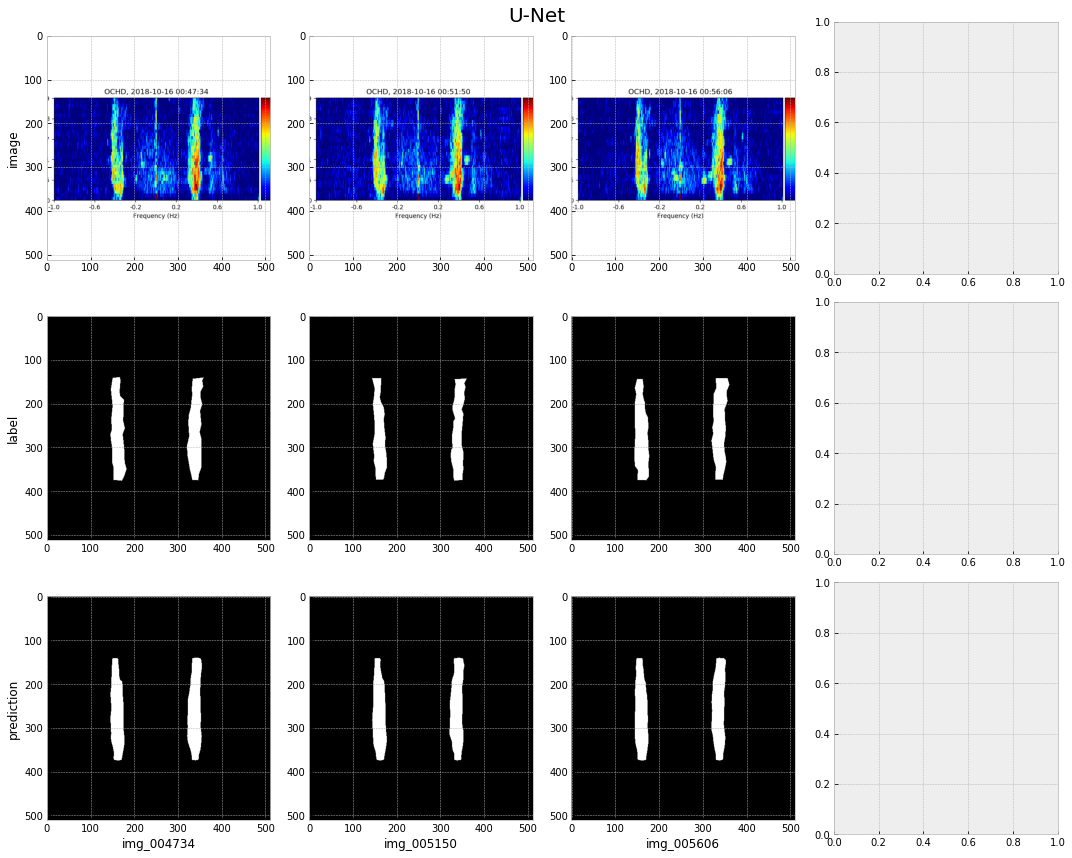

In [14]:
# meanIoU
r_miou = []
l_miou = []

result_dir = './drive/MyDrive/pytorch-unet/results/numpy'
input_dir = osp.join(result_dir, "input_%04d"%i + ".npy")
label_dir = osp.join(result_dir, "label_%04d"%i + ".npy")
output_dir = osp.join(result_dir, "output_%04d"%i + ".npy")
color_dir = './drive/MyDrive/pytorch-unet/test-rgb'
save_dir = './drive/MyDrive/pytorch-unet/results'

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15,12))

for i, fname in enumerate(sorted([file for file in os.listdir(color_dir) if file.startswith("CSQ_OCHD")])) :
  label_dir = osp.join(result_dir, "label_%s"%fname[-10:-4] + ".npy")
  output_dir = osp.join(result_dir, "output_%s"%fname[-10:-4]  + ".npy")

  label = np.load(label_dir)
  output = np.load(output_dir)

  r_iou, l_iou = cal_iou(label, output)
  r_miou.append(r_iou)
  l_miou.append(l_iou)

  img = cv2.imread(osp.join(color_dir, fname))
  img_rsh = 255*np.ones((512, 512,3), dtype=np.uint8)
  img_rsh[16:-16, :, :] = img[:, 64:-64, :]
  make_plot(fig, axes, i, img_rsh, label, output, fname[-10:-4])

plt.suptitle("U-Net", fontsize=20, y=1.00)
plt.tight_layout()
plt.savefig(osp.join(save_dir, "U-Net.png"))

print("######## U-Net mIoU[%] ########")
print("left first order region: {:.2f}".format(100*np.mean(l_miou)))
print("right first order region : {:.2f}".format(100*np.mean(r_miou)))
print("=> total : {:.2f}".format(100*np.mean(r_miou+l_miou)))

print(l_miou)
print(r_miou)
print(np.var(l_miou), np.var(r_miou))

# Dectectron2


In [5]:
def pre_output(output):

  mask = (output[0,:,:]) | (output[1, :,:])
  tmp = np.zeros((mask.shape), dtype=np.int8)
  tmp[mask] = 1
  for x in range(tmp.shape[0]) :
    for y in range(int(tmp.shape[1]*0.5)):
      if tmp[x,-y] == 1 : tmp[x, -y] = 2

  return tmp

######## Detectron2 mIoU[%] ########
left first order region : 81.25
right first order region : 88.63
=> total : 84.94


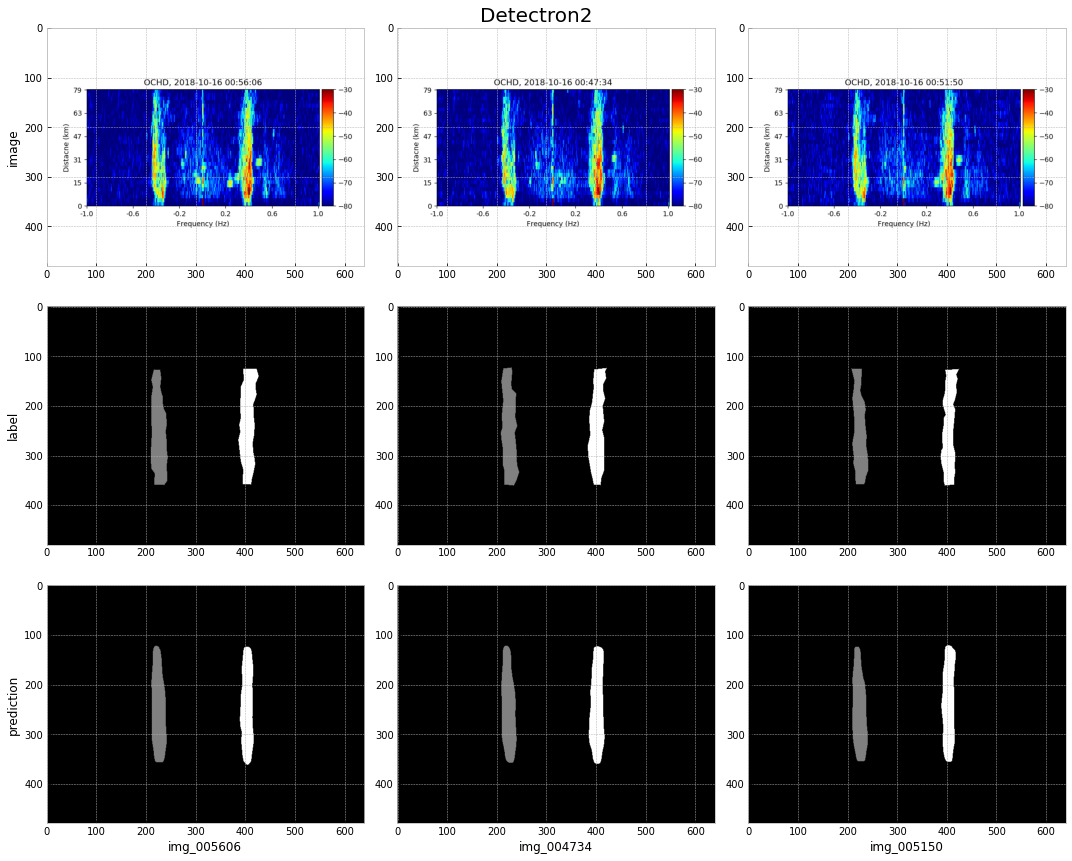

In [6]:
result_dir = './drive/MyDrive/detectron2/results'

# meanIoU
r_miou = []
l_miou = []

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,12))
for i, fname in enumerate([file for file in os.listdir(result_dir) if file.startswith("label")]) :
  label_dir = osp.join(result_dir, fname)
  output_dir = osp.join(result_dir, "output"+fname[5:])
  
  label = np.load(label_dir)
  output = np.load(output_dir)

  mid = int(output.shape[1]*0.5)
  output = pre_output(output)

  r_iou, l_iou = cal_iou(label, output, mid=mid)
  r_miou.append(r_iou)
  l_miou.append(l_iou)

  img = cv2.imread(osp.join(result_dir, "CSQ_OCHD_18_10_16"+fname[5:-4]+'.png'))
  
  make_plot(fig, axes, i, img, label, output, fname[6:12])

plt.suptitle("Detectron2", fontsize=20, y=1.0)
plt.tight_layout()
plt.savefig(osp.join(save_dir, "Detectron2.png"))

print("######## Detectron2 mIoU[%] ########")
print("left first order region : {:.2f}".format(100*np.mean(l_miou)))
print("right first order region : {:.2f}".format(100*np.mean(r_miou)))
print("=> total : {:.2f}".format(100*np.mean(r_miou+l_miou)))

In [7]:
(0.858580644356517 - 0.8493629642522094)/0.8493629642522094*100

1.0852462954307232